In [3]:
import sys
import os
sys.path.append("../")

from data_processors.dataset import load_as_hf_dataset
from config_utils.load_config import load_params_from_yaml, DataParamsSchema


In [4]:
import torch

In [5]:
dataset_params = load_params_from_yaml("dataset_params.yaml", DataParamsSchema)
dataset_params.data_params

DataParams(tokenizer_name='bert-base-uncased', train_data_path='data/processed/train.csv', subset1_path='data/processed/', subset2_path='data/processed/', validate_data_path='data/processed/valid.csv', test_data_path='data/processed/test.csv', masked_data_path='data/masked/', subreddit1='programming', subreddit2='gaming', subreddits=[], mask_prob=0.15)

In [6]:
from pathlib import Path
root_dir = Path().resolve().parents[0]

In [7]:
from datasets import Dataset
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(dataset_params.data_params.tokenizer_name)
dataset = load_as_hf_dataset(root_dir / dataset_params.load_params.raw_data_path)

In [8]:
dataset[0]

{'title': 'The one feature the iPad is really missing.',
 'body': "I don't care about the lack of camera. I never use the one on my MacBook, and even if I did the angle would be terrible on the iPad.\n\nI don't care if third party apps can't run in the background. I don't listen to streaming music.\n\nI don't care that the App Store is a closed system. I can jailbreak for myself and I think the closed system works better for most users.\n\nThe one feature I want is User Accounts and a Guest Account. If this device is meant to be a coffee table computer, it needs to be able to accomadate multiple users.",
 'subreddit': 'apple'}

In [9]:
text = dataset["body"]
text[0]

"I don't care about the lack of camera. I never use the one on my MacBook, and even if I did the angle would be terrible on the iPad.\n\nI don't care if third party apps can't run in the background. I don't listen to streaming music.\n\nI don't care that the App Store is a closed system. I can jailbreak for myself and I think the closed system works better for most users.\n\nThe one feature I want is User Accounts and a Guest Account. If this device is meant to be a coffee table computer, it needs to be able to accomadate multiple users."

In [8]:
import numpy as np

np.mean(np.array([len(x) for x in text]))

# max_len 512 думаю хватит

616.981018981019

In [9]:
inputs = tokenizer(
    text, 
    return_tensors='pt', 
    max_length=512, 
    truncation=True, 
    padding='max_length')

In [10]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [11]:
inputs

{'input_ids': tensor([[ 101, 1045, 2123,  ...,    0,    0,    0],
        [ 101, 1045, 2001,  ...,    0,    0,    0],
        [ 101, 2146, 1013,  ..., 2031, 2246,  102],
        ...,
        [ 101, 2045, 2024,  ...,    0,    0,    0],
        [ 101, 2003, 2009,  ...,    0,    0,    0],
        [ 101, 1045, 2215,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [12]:
tokenizer.special_tokens_map["mask_token"]

'[MASK]'

In [13]:
inputs['input_ids'].shape

torch.Size([1001, 512])

In [14]:
# create random array of floats in equal dimension to input_ids
rand = torch.rand(inputs.input_ids.shape)
rand

tensor([[0.3520, 0.4804, 0.1767,  ..., 0.0441, 0.0798, 0.1684],
        [0.2681, 0.5523, 0.4413,  ..., 0.9734, 0.8403, 0.9980],
        [0.5158, 0.8956, 0.9819,  ..., 0.7384, 0.2273, 0.3699],
        ...,
        [0.8622, 0.5233, 0.0445,  ..., 0.2098, 0.0067, 0.2114],
        [0.0599, 0.1316, 0.2998,  ..., 0.9471, 0.3585, 0.1596],
        [0.9903, 0.9810, 0.7681,  ..., 0.4860, 0.2037, 0.1898]])

In [15]:
dataset_params.data_params.mask_prob

0.15

In [16]:
tokenizer.cls_token_id

101

In [17]:
tokenizer.mask_token_id

103

In [18]:
tokenizer.sep_token_id

102

In [19]:
# Создаем маску, исключая CLS, SEP и паддинг (0)
mask_arr = (rand < dataset_params.data_params.mask_prob) * \
            (inputs.input_ids != tokenizer.cls_token_id) * \
            (inputs.input_ids != tokenizer.sep_token_id) * \
            (inputs.input_ids != 0)  
mask_arr

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False,  True,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [20]:
selection = torch.flatten((mask_arr[0]).nonzero()).tolist()
selection

[3, 15, 22, 28, 36, 38, 52, 64, 67, 74, 89, 93, 117, 129]

In [21]:
inputs['labels'] = inputs.input_ids.detach().clone()
inputs

{'input_ids': tensor([[ 101, 1045, 2123,  ...,    0,    0,    0],
        [ 101, 1045, 2001,  ...,    0,    0,    0],
        [ 101, 2146, 1013,  ..., 2031, 2246,  102],
        ...,
        [ 101, 2045, 2024,  ...,    0,    0,    0],
        [ 101, 2003, 2009,  ...,    0,    0,    0],
        [ 101, 1045, 2215,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[ 101, 1045, 2123,  ...,    0,    0,    0],
        [ 101, 1045, 2001,  ...,    0,    0,    0],
        [ 101, 2146, 1013,  ..., 2031, 2246,  102],
        ...,
      

In [22]:
for i in range(inputs.input_ids.shape[0]):
    selection = torch.flatten((mask_arr[i]).nonzero()).tolist()
    inputs.input_ids[i, selection] = tokenizer.mask_token_id
inputs

{'input_ids': tensor([[ 101, 1045, 2123,  ...,    0,    0,    0],
        [ 101, 1045, 2001,  ...,    0,    0,    0],
        [ 101, 2146, 1013,  ..., 2031, 2246,  102],
        ...,
        [ 101, 2045,  103,  ...,    0,    0,    0],
        [ 101,  103, 2009,  ...,    0,    0,    0],
        [ 101, 1045, 2215,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[ 101, 1045, 2123,  ...,    0,    0,    0],
        [ 101, 1045, 2001,  ...,    0,    0,    0],
        [ 101, 2146, 1013,  ..., 2031, 2246,  102],
        ...,
      

In [23]:
inputs["input_ids"][0]

tensor([  101,  1045,  2123,   103,  1056,  2729,  2055,  1996,  3768,  1997,
         4950,  1012,  1045,  2196,  2224,   103,  2028,  2006,  2026,  6097,
         8654,  1010,   103,  2130,  2065,  1045,  2106,  1996,   103,  2052,
         2022,  6659,  2006,  1996, 25249,  1012,   103,  2123,   103,  1056,
         2729,  2065,  2353,  2283, 18726,  2064,  1005,  1056,  2448,  1999,
         1996,  4281,   103,  1045,  2123,  1005,  1056,  4952,  2000, 11058,
         2189,  1012,  1045,  2123,   103,  1056,  2729,   103,  1996, 10439,
         3573,  2003,  1037,  2701,   103,  1012,  1045,  2064,  7173, 23890,
         2005,  2870,  1998,  1045,  2228,  1996,  2701,  2291,  2573,   103,
         2005,  2087,  5198,   103,  1996,  2028,  3444,  1045,  2215,  2003,
         5310,  6115,  1998,  1037,  4113,  4070,  1012,  2065,  2023,  5080,
         2003,  3214,  2000,  2022,  1037,  4157,  2795,   103,  1010,  2009,
         3791,  2000,  2022,  2583,  2000, 16222,  9626, 13701, 

In [24]:
inputs["input_ids"][1]

tensor([  101,  1045,  2001,  2183,  2000, 28797, 10086,   103,  2806,   103,
         1996,   103,  4942,  5596,   103,  2021,  2059,  1045,  2179,  2023,
          103,  1998, 11323,  2008,  2111,  2031,  2200,  2844,   103,  2055,
         2129,  2037,  2417, 23194,  2323,  2298,   103,   103,  2077,  1045,
         2191,  2151,  3431,  2079,  2017,  2031,  2151, 10740,  2030,   103,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [25]:
# final
inputs = tokenizer(
    text, 
    return_tensors='pt', 
    max_length=512, 
    truncation=True, 
    padding='max_length')

inputs['labels'] = inputs.input_ids.detach().clone()

# create random array of floats in equal dimension to input_ids
rand = torch.rand(inputs.input_ids.shape)

# create mask, without CLS, SEP and padding (0)
mask_arr = (rand < dataset_params.data_params.mask_prob) * \
            (inputs.input_ids != tokenizer.cls_token_id) * \
            (inputs.input_ids != tokenizer.sep_token_id) * \
            (inputs.input_ids != 0)  

selection = torch.flatten((mask_arr[0]).nonzero()).tolist()

for i in range(inputs.input_ids.shape[0]):
    selection = torch.flatten((mask_arr[i]).nonzero()).tolist()
    inputs.input_ids[i, selection] = tokenizer.mask_token_id

In [26]:
inputs["input_ids"][4]

tensor([  101,   103,  2572,   103,  4121,   103,   103,  1010,  1045,   103,
         2572,   103,  2000,  2505,  2104,  1996,  3103,  1012,   103,  2065,
         1045,  2572,  2108,  6135,  7481,  2026,  2398,  2091,  5440,  4996,
          103,   103,  4095,  1010,  5164,   103,  5043,  1010,  1998,   103,
         5743,   103,  2061,  2006,  1012,   103,  2001,  2074,   103,  2000,
          103,  2070, 12369,  2004,   103,  2339,  1006,   103,  4092,  1007,
         2111,   103,  1005,  1056,  2507,  4996,  1013,  2189,   103,  2023,
          103,  1037,  4189,  6073,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [27]:
import torch

torch.save(inputs, 'tokenized_dataset.pt')


In [28]:
inputs_loaded = torch.load('tokenized_dataset.pt')

/var/folders/zg/4scz2l1x7f13kl3dkr2812840000gn/T/ipykernel_24274/3123583274.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inputs_loaded = torch.load('tokenized_dataset

In [29]:
torch.flatten((inputs_loaded["input_ids"][0] == inputs["input_ids"][0]).nonzero()).shape

torch.Size([512])

In [30]:
tokenizer.vocab_size

30522

# Train model

In [31]:
from config_utils.load_config import load_params_from_yaml, ModelParamsSchema

model_params = load_params_from_yaml("model_params.yaml", ModelParamsSchema)

In [32]:
from model.model_main import MoETransformerEncoder

model = MoETransformerEncoder(**model_params.__dict__)

In [33]:
model

MoETransformerEncoder(
  (input_emb): InputEmbedding(
    (input_embedding): Embedding(30522, 256)
    (positional_encoding): PositionalEncoding()
  )
  (moe_transformer): Sequential(
    (0): EncoderBlock(
      (multi_head_attention): MultiHeadAttention_Parallel(
        (key): Linear(in_features=256, out_features=4096, bias=False)
        (query): Linear(in_features=256, out_features=4096, bias=False)
        (value): Linear(in_features=256, out_features=4096, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=4096, out_features=256, bias=True)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (moe_block): MoELayer(
        (gate): Linear(in_features=256, out_features=4, bias=False)
        (experts): ModuleList(
          (0-3): 4 x PositionwiseFeedForward(
            (linear1): Linear(in_features=256, out_features=512, bias=True)
            (linear2): Linear(in_features=512, out_features=256, bias=True)
 

In [34]:
type(inputs_loaded)

transformers.tokenization_utils_base.BatchEncoding

In [35]:
inputs_loaded['input_ids'].shape, inputs_loaded['attention_mask'].shape, inputs_loaded['labels'].shape

(torch.Size([1001, 512]), torch.Size([1001, 512]), torch.Size([1001, 512]))

In [36]:
import datasets
from datasets import DatasetDict

data_dict = {
    'input_ids': torch.tensor(inputs_loaded['input_ids']),
    'attention_mask': torch.tensor(inputs_loaded['attention_mask']),
    'labels': torch.tensor(inputs_loaded['labels'])
}

dataset = Dataset.from_dict(data_dict)
dataset = DatasetDict({'train': dataset})
dataset.set_format(type='torch')
dataset

/var/folders/zg/4scz2l1x7f13kl3dkr2812840000gn/T/ipykernel_24274/968484900.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(inputs_loaded['input_ids']),
/var/folders/zg/4scz2l1x7f13kl3dkr2812840000gn/T/ipykernel_24274/968484900.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(inputs_loaded['attention_mask']),
/var/folders/zg/4scz2l1x7f13kl3dkr2812840000gn/T/ipykernel_24274/968484900.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(inputs_loaded['label

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1001
    })
})

In [11]:
from torch.utils.data import DataLoader

from config_utils.load_config import (
    load_params_from_yaml,
    TrainParamsSchema
)

train_params = load_params_from_yaml("train_params.yaml", TrainParamsSchema)
train_params

TrainParams(batch_size=16, n_epochs=3, learning_rate=0.001, gradient_accumulation_steps=1, experiment_name='mixture_of_experts', weight_decay=1e-05, warmup_proportion=0.1, tokenizer_mask_id=103, eval_steps=20, save_steps=1000, save_path='.', random_seed=11)

In [38]:
dataloader = DataLoader(dataset['train'], batch_size=train_params.batch_size, shuffle=True)
len(dataloader)

63

In [39]:
device = model_params.__dict__["device"]
model.to(device)

MoETransformerEncoder(
  (input_emb): InputEmbedding(
    (input_embedding): Embedding(30522, 256)
    (positional_encoding): PositionalEncoding()
  )
  (moe_transformer): Sequential(
    (0): EncoderBlock(
      (multi_head_attention): MultiHeadAttention_Parallel(
        (key): Linear(in_features=256, out_features=4096, bias=False)
        (query): Linear(in_features=256, out_features=4096, bias=False)
        (value): Linear(in_features=256, out_features=4096, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=4096, out_features=256, bias=True)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (moe_block): MoELayer(
        (gate): Linear(in_features=256, out_features=4, bias=False)
        (experts): ModuleList(
          (0-3): 4 x PositionwiseFeedForward(
            (linear1): Linear(in_features=256, out_features=512, bias=True)
            (linear2): Linear(in_features=512, out_features=256, bias=True)
 

In [40]:
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F

optimizer = AdamW(model.parameters(), lr=train_params.learning_rate)

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
import matplotlib.pyplot as plt

def draw_gate_stats(gate_stats):
    plt.hist(gate_stats)
    plt.xticks(ticks=list(set(gate_stats)))
    plt.title("Распределение выбранных экспертов по токенам")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/63 [00:00<?, ?it/s]

tensor(10.3816, grad_fn=<NllLossBackward0>) 0.0


  2%|▏         | 1/63 [00:05<06:04,  5.87s/it]

tensor(9.7749, grad_fn=<NllLossBackward0>) 0.032


  3%|▎         | 2/63 [00:11<05:55,  5.82s/it]

tensor(9.6239, grad_fn=<NllLossBackward0>) 0.032397408207343416


  5%|▍         | 3/63 [00:16<05:31,  5.52s/it]

tensor(9.2567, grad_fn=<NllLossBackward0>) 0.05013927576601671


  5%|▍         | 3/63 [00:21<07:00,  7.00s/it]


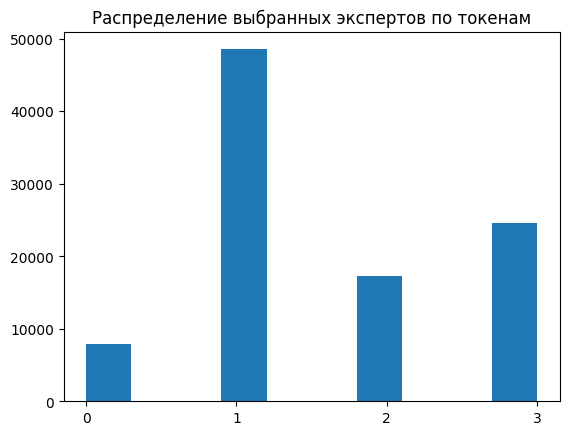

In [43]:
from tqdm import tqdm

torch.cuda.manual_seed(train_params.random_seed)
np.random.seed(train_params.random_seed)    
torch.manual_seed(train_params.random_seed)

n_epochs = train_params.n_epochs
gates_stats = []

for epoch in range(1):
    loop = tqdm (dataloader, leave=True)
    model.train()
    cnt = 0
    for batch in loop:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        output, gate_respond = model(input_ids)

        gates_stats.extend(gate_respond.flatten().tolist())

        mask = (input_ids == tokenizer.mask_token_id)
        masked_output = output[mask]
        masked_labels = labels[mask]

        if masked_output.size(0) > 0:
            loss = F.cross_entropy(masked_output, masked_labels)
            _, predicted = torch.max(masked_output, dim=-1)
            correct_predictions = (predicted == masked_labels).sum().item()
            total_predictions = masked_labels.size(0)
            accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
        else:
            loss = torch.tensor(0.0, requires_grad=True).to(device)
            accuracy = 0.0
            
        print(loss, accuracy)
        loss.backward()
        optimizer.step()
        cnt += 1
        if cnt >= 4:
            break
    break
    
    # TODO: write the validation process
    # model.eval()
    # with torch.no_grad():
    #     loop = tqdm (val_dataloader, leave=True)
    #     for batch in loop:
    #         pass

draw_gate_stats(gates_stats)

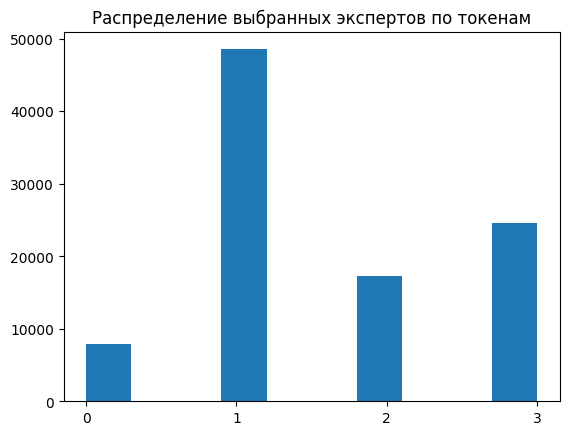

In [44]:
draw_gate_stats(gates_stats)

In [46]:
gates_stats.count(0), gates_stats.count(1), gates_stats.count(2), gates_stats.count(3)

(7877, 48516, 17295, 24616)